# DataLoad

In [ ]:
!mkdir /content/masks/
!mkdir /content/masks/scratch/
!mkdir /content/masks/dent/
!mkdir /content/masks/broken/
!mkdir /content/masks/spacing/

In [ ]:
!mkdir /content/img_a/
!mkdir /content/img_b/
!mkdir /content/img_c/
!mkdir /content/img_d/

In [ ]:
import json
import os
import skimage.draw
import cv2
import numpy as np
import matplotlib.pyplot as plt
import shutil
from PIL import Image

from tqdm.notebook import tqdm

In [ ]:
## json file load
!gdown 1Zmutg1h83EhSq5OCt-yU2wVqBNEtRuBM
!gdown 1tpnzjGpqUkeQJtKfJPX-NKq5xDLsWKJi
!gdown 15qW965JVTWthkSEPI9n4wv5IHiAuHB6l
!gdown 1e6lXvrinhfmT0CZ2biWgo77MgLNus5KJ

Downloading...
From: https://drive.google.com/uc?id=1Zmutg1h83EhSq5OCt-yU2wVqBNEtRuBM
To: /content/규원_1_multilabel.zip
100% 17.1M/17.1M [00:00<00:00, 108MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1tpnzjGpqUkeQJtKfJPX-NKq5xDLsWKJi
To: /content/규원_2_multilabel.zip
100% 25.9M/25.9M [00:00<00:00, 144MB/s] 
Downloading...
From: https://drive.google.com/uc?id=15qW965JVTWthkSEPI9n4wv5IHiAuHB6l
To: /content/coco_multilabel_220706.zip
100% 7.20M/7.20M [00:00<00:00, 69.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1e6lXvrinhfmT0CZ2biWgo77MgLNus5KJ
To: /content/handmade.zip
100% 29.7M/29.7M [00:00<00:00, 111MB/s] 


In [ ]:
!unzip /content/규원_1_multilabel.zip -d /content/img_a/
!unzip /content/규원_2_multilabel.zip -d /content/img_b/
!unzip /content/coco_multilabel_220706.zip -d /content/img_c/
!unzip /content/handmade.zip -d /content/img_d/

Archive:  /content/규원_1_multilabel.zip
   creating: /content/img_a/img/
  inflating: /content/img_a/img/016.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._016.jpg  
  inflating: /content/img_a/img/017.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._017.jpg  
  inflating: /content/img_a/img/029.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._029.jpg  
  inflating: /content/img_a/img/015.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._015.jpg  
  inflating: /content/img_a/img/014.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._014.jpg  
  inflating: /content/img_a/img/028.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._028.jpg  
  inflating: /content/img_a/img/010.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._010.jpg  
  inflating: /content/img_a/img/038.jpg  
  inflating: /content/img_a/__MACOSX/규원_1_multilabel/._038.jpg  
  inflating: /content/img_a/img/039.jpg  
  inflating: /content/img_a/__

# Load json

In [ ]:
json_path_a = '/content/img_a/img/규원_1_multilabel.json'
json_path_b = '/content/img_b/img/규원_2_multilabel.json'
json_path_c = '/content/img_c/img/coco_multilabel.json'
json_path_d = '/content/img_d/img/via_project_7Jul2022_11h8m.json'

In [ ]:
## json.load : json -> dict , json문자열을 python 객체로 변환
annotations1 = json.load(open(os.path.join(json_path_b),'r',encoding="utf8",errors='ignore')) ## json_path_o 변경
annotations = annotations1['_via_img_metadata']

In [ ]:
id_list = annotations1['_via_image_id_list']

# Binary data Making

In [ ]:
## 저장시킬 디렉토리 생성
!mkdir /content/bin_dataset/

!mkdir /content/bin_dataset/image/
!mkdir /content/bin_dataset/masks/

!mkdir /content/bin_dataset/masks/scratch/
!mkdir /content/bin_dataset/masks/dent/
!mkdir /content/bin_dataset/masks/broken/
!mkdir /content/bin_dataset/masks/spacing/

In [ ]:
## 각 class 별로 polygon2mask

t_list = ['a', 'b', 'c', 'd'] # img 경로
j_list = [json_path_a, json_path_b, json_path_c, json_path_d] # json경로
for t, j in zip(t_list, j_list):

    annotations1 = json.load(open(os.path.join(j),'r',encoding="utf8",errors='ignore')) ## json_path_o 변경
    annotations = annotations1['_via_img_metadata']

    id_list = annotations1['_via_image_id_list']

    for id in tqdm(id_list):
        a = annotations[id]
        f_name = a['filename']
        region = a['regions']

        file_name = f_name.split('.')[0]

        img = Image.open(f'/content/img_{t}/img/' + f_name)    ## img_o 변경
        img = np.array(img)
        img_s = img.shape
        
        scratch_img = np.ones((img_s[0], img_s[1])) # np.ones : (img_s[0],img_s[1])사이즈만큼 1로 가득채운 array 생성
        dent_img = np.ones((img_s[0], img_s[1]))
        broken_img = np.ones((img_s[0], img_s[1]))
        spacing_img = np.ones((img_s[0], img_s[1]))

        for reg in region:
            try:
                att = reg['region_attributes']['class'] # class_id 변수지정, att = 'scratch','dent','spacing','broken'

                if att == 'scratch': # att(class_id)가 'scratch'이면
                    all_x = reg['shape_attributes']['all_points_x'] # 모든 x좌표 추출
                    all_y = reg['shape_attributes']['all_points_y'] # 모든 y좌표 추출
                    rr, cc = skimage.draw.polygon(all_y, all_x) # skimage.draw.polygon(r,c,shape=None) >> r:폴리곤 행 좌표(y), c:폴리곤 열 좌표(x)
                    scratch_img[rr, cc] = 0 # 마스크 부분을 0으로 채움

                    
                
                elif att == 'dent':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    dent_img[rr, cc] = 0


                elif att == 'broken':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    broken_img[rr, cc] = 0

                elif att == 'spacing':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    spacing_img[rr, cc] = 0


                else: pass

            except:
                pass
        
        scratch_img = Image.fromarray(scratch_img).convert("L") # Image.fromarray를 통해 numpy를 image로 불러옴
        dent_img = Image.fromarray(dent_img).convert("L")       # convert("L") : image를 grayscale로
        broken_img = Image.fromarray(broken_img).convert("L")
        spacing_img = Image.fromarray(spacing_img).convert("L")
        
        img = Image.fromarray(img).convert("RGB") # 원본 이미지 RGB이미지로 변환
        
        scratch_img = scratch_img.resize((512, 512)) # 512X512로 리사이징
        dent_img = dent_img.resize((512, 512))
        broken_img = broken_img.resize((512, 512))
        spacing_img = spacing_img.resize((512, 512))
        
        img = img.resize((512, 512)) # 원본 이미지 512X512로 리사이징

        scratch_img.save(f'/content/bin_dataset/masks/scratch/{t}_{file_name}.png', "PNG") # file이름은 그대로 PNG 이미지 저장
        dent_img.save(f'/content/bin_dataset/masks/dent/{t}_{file_name}.png', "PNG")
        broken_img.save(f'/content/bin_dataset/masks/broken/{t}_{file_name}.png', "PNG")
        spacing_img.save(f'/content/bin_dataset/masks/spacing/{t}_{file_name}.png', "PNG")        

        img.save(f'/content/bin_dataset/image/{t}_{file_name}.png', "PNG") # 원본이미지 file이름은 그대로 PNG 이미지 저장

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

  0%|          | 0/111 [00:00<?, ?it/s]

In [ ]:
## dataset check
main_dir = '/content/bin_dataset/masks/' # 경로설정

mask_a = os.listdir(main_dir + 'scratch') # scratch 경로안의 파일들을 리스트로 반환
mask_b = os.listdir(main_dir + 'dent')    # dent 경로안의 파일들을 리스트로 반환
mask_c = os.listdir(main_dir + 'spacing') # spacing 경로안의 파일들을 리스트로 반환
mask_d = os.listdir(main_dir + 'broken')  # broken 경로안의 파일들을 리스트로 반환

mask_list = [mask_a, mask_b, mask_c, mask_d] # mask_a,b,c,d 리스트를 하나로 묶음
mask_name = ['scratch/', 'dent/', 'spacing/', 'broken/']

mask_file_name = [] # 빈 리스트 생성
for mask, name in zip(mask_list, mask_name): # mask : mask_a,b,c,d / name : 'scratch/','dent/','spacing/','broken/'
    name_list = [] # name_list 생성
    for a in mask: # a : mask_a,b,c,d 안의 파일
        a_img = Image.open(main_dir + name + a) # (마스크 경로 + 'scratch/','dent/','spacing/','broken/' + 파일) 을 이미지로 불러옴
        a_img = np.array(a_img) # 이미지를 array로 
        if a_img.min() != a_img.max(): # array의 최솟값과 최댓값이 다르면
            name_list.append(a) # 빈 리스트에 파일을 append
    mask_file_name.append(name_list) # mask_file_name 빈 리스트에 name_list append

mask_file_name

In [ ]:
len(mask_file_name[0]), len(mask_file_name[1]), len(mask_file_name[2]), len(mask_file_name[3])

(303, 287, 191, 115)

In [ ]:
!mkdir /content/make_data/

In [ ]:
!mkdir /content/make_data/1/
!mkdir /content/make_data/1/images/
!mkdir /content/make_data/1/masks/

!mkdir /content/make_data/2/
!mkdir /content/make_data/2/images/
!mkdir /content/make_data/2/masks/

!mkdir /content/make_data/3/
!mkdir /content/make_data/3/images/
!mkdir /content/make_data/3/masks/

!mkdir /content/make_data/4/
!mkdir /content/make_data/4/images/
!mkdir /content/make_data/4/masks/

In [ ]:
## shutil.copyfile을 사용해 새로만든 디렉토리에 class별로 파일복사
for i, j in zip(mask_name, range(0, 4)):
    for a in mask_file_name[j]:
        shutil.copyfile(f'/content/bin_dataset/image/{a}', f'/content/make_data/{j + 1}/images/{a}')
        shutil.copyfile(f'/content/bin_dataset/masks/{i + a}', f'/content/make_data/{j + 1}/masks/{a}')

In [ ]:
!zip png_png_512resize_bg1_binary_data220728.zip -r ./make_data

  adding: make_data/ (stored 0%)
  adding: make_data/4/ (stored 0%)
  adding: make_data/4/masks/ (stored 0%)
  adding: make_data/4/masks/a_086.png (deflated 77%)
  adding: make_data/4/masks/a_050.png (deflated 33%)
  adding: make_data/4/masks/d_0243.png (deflated 57%)
  adding: make_data/4/masks/d_0267.png (deflated 59%)
  adding: make_data/4/masks/b_0122.png (deflated 42%)
  adding: make_data/4/masks/d_0256.png (deflated 68%)
  adding: make_data/4/masks/a_063.png (deflated 48%)
  adding: make_data/4/masks/b_0132.png (deflated 87%)
  adding: make_data/4/masks/a_026.png (deflated 67%)
  adding: make_data/4/masks/b_0171.png (deflated 50%)
  adding: make_data/4/masks/a_067.png (deflated 48%)
  adding: make_data/4/masks/d_0307.png (deflated 33%)
  adding: make_data/4/masks/c_71.png (deflated 57%)
  adding: make_data/4/masks/c_33.png (deflated 48%)
  adding: make_data/4/masks/a_069.png (deflated 40%)
  adding: make_data/4/masks/d_0293.png (deflated 42%)
  adding: make_data/4/masks/c_47.png 

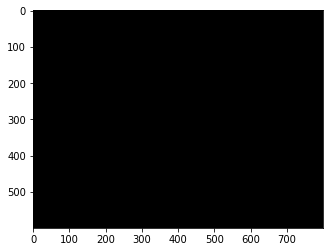

In [ ]:
test_a = cv2.imread('/content/masks/dent/023.jpg')

plt.imshow(test_a)

In [ ]:
!zip png_png_512resize_bg4_binary_220728.zip -r ./bin_dataset

  adding: bin_dataset/ (stored 0%)
  adding: bin_dataset/masks/ (stored 0%)
  adding: bin_dataset/masks/dent/ (stored 0%)
  adding: bin_dataset/masks/dent/c_79.png (deflated 91%)
  adding: bin_dataset/masks/dent/c_15.png (deflated 91%)
  adding: bin_dataset/masks/dent/a_087.png (deflated 91%)
  adding: bin_dataset/masks/dent/d_0297.png (deflated 91%)
  adding: bin_dataset/masks/dent/b_0188.png (deflated 91%)
  adding: bin_dataset/masks/dent/a_021.png (deflated 91%)
  adding: bin_dataset/masks/dent/d_0262.png (deflated 91%)
  adding: bin_dataset/masks/dent/a_086.png (deflated 91%)
  adding: bin_dataset/masks/dent/d_0211.png (deflated 91%)
  adding: bin_dataset/masks/dent/c_52.png (deflated 91%)
  adding: bin_dataset/masks/dent/b_0144.png (deflated 91%)
  adding: bin_dataset/masks/dent/a_059.png (deflated 91%)
  adding: bin_dataset/masks/dent/a_050.png (deflated 91%)
  adding: bin_dataset/masks/dent/d_0225.png (deflated 91%)
  adding: bin_dataset/masks/dent/d_0290.png (deflated 91%)
  ad

# Multi data Making

In [ ]:
!mkdir ./multi_mask_data
!mkdir ./multi_mask_data/images
!mkdir ./multi_mask_data/masks

## padding

In [ ]:
## img : 패딩과 리사이징 할 이미지
## set_size : 리사이징 할 크기
## ex) padding(CarDamage.png, 512) -> CarDamage.png를 512x512로 리사이징하며 zero padding 시켜줌
def padding(img, set_size):

    h,w,c = img.shape # img shape ( height, weight, channel ) 를 h,w,c 변수로 저장

    if h<w: # 원본 이미지에서 h<w일때
      new_width = set_size # 리사이즈할 크기를 입력( set_size )
      new_height = int(new_width*(h/w)) # 리사이즈하되 원본의 h,w 비율을 가져가기위한 계산
    else:
      new_height = set_size
      new_width = int(new_height*(w/h)) 

    if max(h,w) < set_size:
      img = cv2.resize(img, (new_height, new_width), cv2.INTER_CUBIC) # INTER_CUBIC : 사이즈를 크게할 떄 사용하는 보간법
    else:
      img = cv2.resize(img, (new_height, new_width), cv2.INTER_AREA) # INTER_AREA : 사이즈를 작게할 때 사용하는 보간법

    # h,w,c = img.shape
    
    # delta_w = set_size - w
    # delta_h = set_size - h
    # top, bottom = delta_h//2,delta_h-(delta_h//2)
    # left, right = delta_w//2,delta_w-(delta_w//2)

    # new_img=cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,value=[0,0,0])
    return img

In [ ]:
def mask_padding(img, set_size):

    h,w = img.shape

    if h<w:
      new_width = set_size
      new_height = int(new_width*(h/w))
    else:
      new_height = set_size
      new_width = int(new_height*(w/h))

    if max(h,w) < set_size:
      imgs = cv2.resize(img, (new_height, new_width), cv2.INTER_CUBIC)
    else:
      imgs = cv2.resize(img, (new_height, new_width), cv2.INTER_AREA)

    # h,w = img.shape
    
    # delta_w = set_size - w
    # delta_h = set_size - h
    # top, bottom = delta_h//2,delta_h-(delta_h//2)
    # left, right = delta_w//2,delta_w-(delta_w//2)

    # new_img=cv2.copyMakeBorder(img,top,bottom,left,right,cv2.BORDER_CONSTANT,value=[0,0])
    return imgs

## make mask

In [ ]:
t_list = ['a', 'b', 'c', 'd']
j_list = [json_path_a, json_path_b, json_path_c, json_path_d]
for t, j in zip(t_list, j_list):

    annotations1 = json.load(open(os.path.join(j),'r',encoding="utf8",errors='ignore')) ## json_path_o 변경
    annotations = annotations1['_via_img_metadata']

    id_list = annotations1['_via_image_id_list']

    for id in tqdm(id_list):
        a = annotations[id]
        f_name = a['filename']
        region = a['regions']

        file_name = f_name.split('.')[0]
        # print(f_name, file_name)

        img = Image.open(f'/content/img_{t}/img/' + f_name)    ## img_o 변경
        img = np.array(img)

        img_s = img.shape
        multi_img = np.zeros((img_s[0] + 1, img_s[1] + 1, 3))

        # print(multi_img)

        for reg in region:
                try:
                    att = reg['region_attributes']['class']
                except:
                    pass
                if att == 'dent':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    # print('dent', all_y, all_x)
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    # print(rr, cc)
                    multi_img[rr, cc, :] = [255, 0, 0]
                
                elif att == 'spacing':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    # print('spacing', all_y, all_x)
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    # print(rr, cc)
                    multi_img[rr, cc, :] = [0, 255, 0]

                elif att == 'broken':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    # print('broken', all_y, all_x)
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    # print(rr, cc)
                    multi_img[rr, cc, :] = [0, 0, 255]

                elif att == 'scratch':
                    all_x = reg['shape_attributes']['all_points_x']
                    all_y = reg['shape_attributes']['all_points_y']
                    # print('scratch', all_y, all_x)
                    rr, cc = skimage.draw.polygon(all_y, all_x)
                    # print(rr, cc)
                    multi_img[rr, cc, :] = [255, 255, 255]

                else: pass

        # pad_img = padding(img, 512)
        # pad_mask = mask_padding(multi_img, 512)
        
        # r_pad_img = Image.fromarray(pad_img)
        # r_pad_mask = Image.fromarray(pad_mask).convert("P")
       
        img = cv2.resize(img, (512, 512), cv2.INTER_AREA) 
        multi_img = cv2.resize(multi_img, (512, 512), cv2.INTER_AREA) 
        print(img.shape)
        print(multi_img.shape)

        # print(pad_img.min(), pad_img.max())
        # print(pad_mask.min(), pad_mask.max())

        pad_img = Image.fromarray(img.astype(np.uint8))
        pad_mask = Image.fromarray(multi_img.astype(np.uint8))

        # print(pad_img.size)
        # print(pad_mask.size)
        # plt.imshow(pad_img)
        # plt.show()
        # plt.imshow(padding_mask)
        # plt.show()

        # pad_img.save(f'/content/multi_mask_data2/images/{t}_{f_name}')   ## o_ 변경
        pad_img.save(f'/content/multi_mask_data/images/{t}_{file_name}.png', "PNG")   ## o_ 변경
        pad_mask.save(f'/content/multi_mask_data/masks/{t}_{file_name}.png', "PNG")   ## o_ 변경

        # cv2.imwrite(f'/content/multi_mask_data/images/d_{f_name}', pad_img)     ## o_ 변경
        # shutil.copy(f"/content/img_{t}/img/" + f_name, "/content/multi_mask_data/images/" + f'{t}_' + f_name)    ## img_o, o_ 변경

In [ ]:
name = 'a_01'

test_img = Image.open('/content/multi_mask_data/images/' + name + '.png')
test_mask = Image.open('/content/multi_mask_data/masks/' + name + '.png')

test_img = np.array(test_img)
test_mask = np.array(test_mask)

test_img.shape, test_mask.shape

((512, 512, 3), (512, 512))

# Test

In [ ]:
import numpy as np
 
def make_colormap(num=256):
   def bit_get(val, idx):
       return (val >> idx) & 1
 
   colormap = np.zeros((num, 3), dtype=int)
   ind = np.arange(num, dtype=int)
 
   for shift in reversed(list(range(8))):
       for channel in range(3):
           colormap[:, channel] |= bit_get(ind, channel) << shift
       ind >>= 3
 
   return colormap
 
cmap = make_colormap(256).tolist()
palette = [value for color in cmap for value in color]
print(cmap, "\n", palette)

이미지 파일 이름 : /content/multi_mask_data/masks/a_0100.png
이미지 파일형식(format) : PNG
이미지 용량(size) : (512, 512)
이미지 색상모드 : P
이미지 width : 512
이미지 height : 512
(512, 512) 4 0


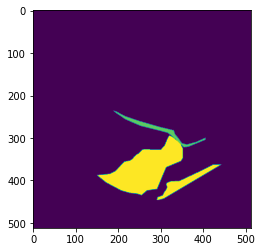

(512, 512) 4 0
(512, 512) 0 0
(512, 512) 0 0
(512, 512) 0 0


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


In [ ]:
import cv2
import numpy as np

import matplotlib.pyplot as plt
import imghdr

from PIL import Image

image_data = Image.open('/content/multi_mask_data/masks/a_0100.png')

print(f'이미지 파일 이름 : {image_data.filename}')
print(f'이미지 파일형식(format) : {image_data.format}')
print(f'이미지 용량(size) : {image_data.size}')
print(f'이미지 색상모드 : {image_data.mode}')
print(f'이미지 width : {image_data.width}')
print(f'이미지 height : {image_data.height}') 


# Image data to save = image_data(numpy.ndarray)
label_img = np.array(image_data)
print(label_img.shape, label_img.max(), label_img.min())
plt.imshow(label_img * 30)
plt.show()
# if image array has BGR order
# label_img = cv2.cvtColor(label_img, cv2.COLOR_BGR2RGB)
print(label_img.shape, label_img.max(), label_img.min())
# Create an unsigned-int (8bit) empty numpy.ndarray of the same size (shape)
img_png = np.zeros((label_img.shape[0], label_img.shape[1]), np.uint8)
print(img_png.shape, img_png.max(), img_png.min())
 
# Assign index to empty ndarray. Finding pixel location using np.where.
# If you don't use np.where, you have to run a double for-loop for each row/column.
for index, val_col in enumerate(cmap):
    img_png[np.where(np.all(label_img == val_col, axis=-1))] = index

print(img_png.shape, img_png.max(), img_png.min())
# Convert ndarray with index into Image object (P mode) of PIL package
img_png = Image.fromarray(img_png).convert('P')
# Palette information injection
img_png.putpalette(palette)
print(np.array(img_png).shape, np.array(img_png).max(), np.array(img_png).min())
# save image
# img_png.save('output.png')

(512, 512, 3) 0 0


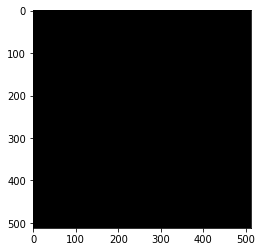

In [ ]:
import matplotlib.pyplot as plt

test_img = cv2.imread('/content/output.png')
test_img = np.array(test_img)
print(test_img.shape, test_img.max(), test_img.min())
plt.imshow(test_img * 30)
plt.show()